In [13]:
import numpy as np
import matplotlib.pyplot as plt

# we work with the dampened oscillator d^2z/dt^2 + 2w(xi)dz/dt + w^2z = 0
# we converted to a system in x = (z, dz/dt)


# global parameters
T = 25000                   # number of time steps
dt = 0.001                  # time step
w = 1.                      # omega
xi = 0.001                  # xi
H = np.array([[1., 0]])     # measurement matrix
R = np.array(5)             # variance of measurement error
I = np.identity(2)          # identity matrix
x0 = np.random.multivariate_normal([0, 0], I)  # initial condition

A = np.array([[0, 1], [-w**2, -2 * xi * w]])  # matrix of system
M = I + dt * A                   # forecasting matrix

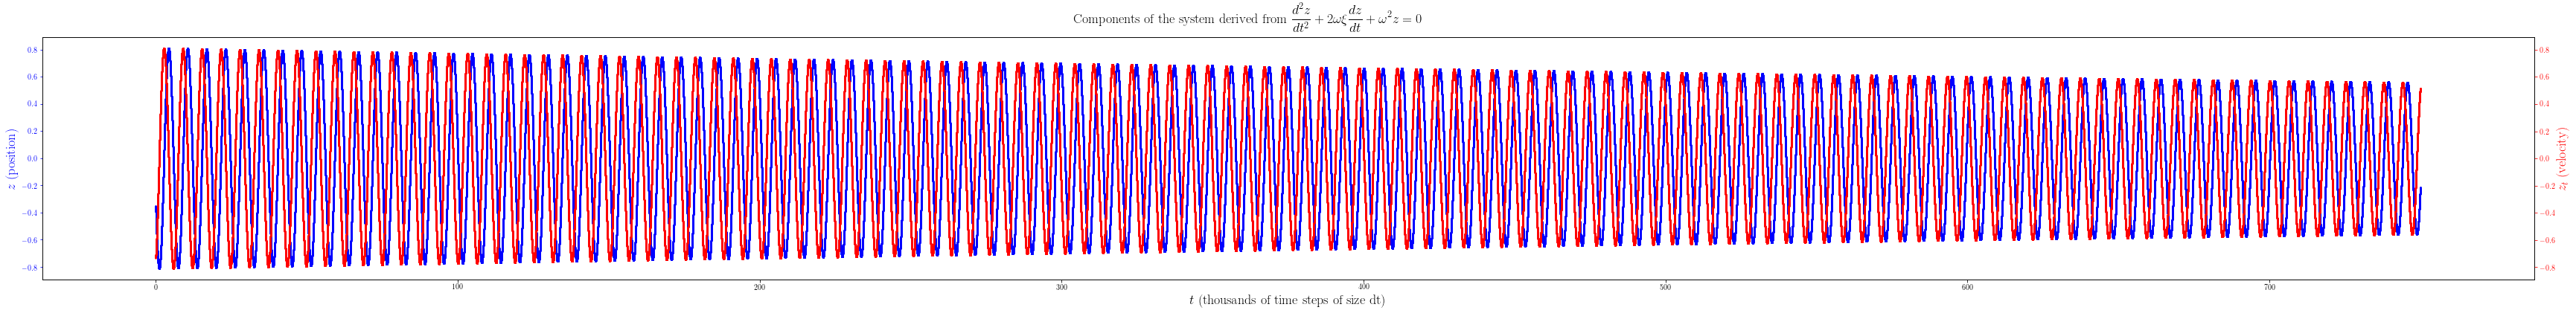

In [22]:
# generate numerical solution and plot
# to illustrate dampening, stack n plots of width T
n = 30
times = [0 + k * dt for k in range(n*T+1)]
true_xs = [x0]
for k in range(n*T):
    true_xs += [M @ true_xs[-1]]
true_zs = [x[0] for x in true_xs]
true_zts = [x[1] for x in true_xs]

fig, z_axis = plt.subplots(figsize=(60, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig.suptitle('Components of the system derived from '
             r"$\displaystyle \frac{d^2z}{dt^2} + 2\omega\xi \frac{dz}{dt} + \omega^2 z = 0$", fontsize=18, fontweight='bold')
z_axis.scatter(times, true_zs, s=1, c=(0, 0, 1))
z_axis.set_xlabel(r"$t$"' (thousands of time steps of size dt)',
                  fontsize=18, fontweight='bold')
# Make the y-axis label, ticks and tick labels match the line color.
z_axis.set_ylabel(r"$z$" ' (position)', color='b',
                  fontsize=18, fontweight='bold')
z_axis.tick_params('y', colors='b')
zt_axis = z_axis.twinx()
zt_axis.scatter(times, true_zts, s=1, c=(1, 0, 0))
zt_axis.set_ylabel(r"$z_t$" ' (velocity)', color='r', fontsize=18,
                   fontweight='bold')
zt_axis.tick_params('y', colors='r')
plt.show()

In [15]:
# time interval was long to illustrate dampening; cut back
times = times[:T+1]
true_xs = true_xs[:T+1]
true_zs = true_zs[:T+1]
true_zts = true_zts[:T+1]

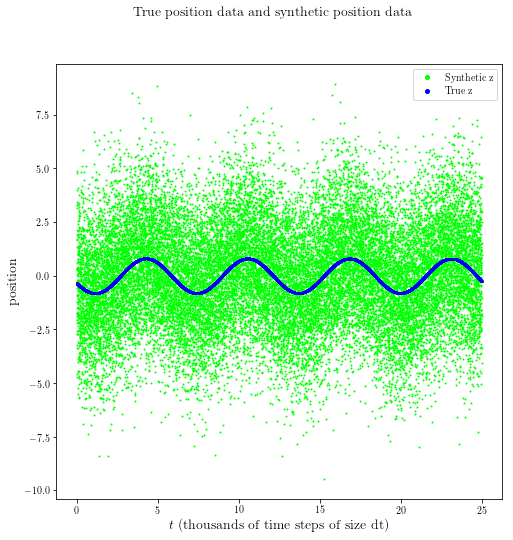

In [16]:
# generate synthetic data and plot
synth_ys = [H @ x + np.random.normal(0, np.sqrt(R)) for x in true_xs]
plt.figure(figsize=(8, 8))
plt.scatter(times, synth_ys, s=1, c=(0, 1, 0))
plt.scatter(times, true_zs, s=1, c=(0, 0, 1))
plt.suptitle('True position data and synthetic position data',
             fontsize=14, fontweight='bold')

plt.xlabel(r"$t$"' (thousands of time steps of size dt)',
                  fontsize=14, fontweight='bold')
plt.ylabel('position', fontsize=14, fontweight='bold')
plt.legend(['Synthetic z', 'True z'], markerscale=4)
plt.show()

In [17]:
# kalman filter
# initialize lists of analysis means (2x1 column vectors)
# covariacnes (2x2 matrices), and gains (2x1 column vectors)
kalman_mus = [np.array([[0, 0]]).T]
kalman_Ps = [I]
kalman_gains = []
for k in range(T):
    # get previous analysis mean and covariance
    mu_last = kalman_mus[-1]
    P_last = kalman_Ps[-1]

    # forecasting step
    mu_f = M @ mu_last
    P_f = M @ P_last @ M.T
    # here R.T + (H @ P_f @ H.T).T is 1x1, but this generalizes
    K = np.linalg.solve(R.T + (H @ P_f @ H.T).T, H @ P_f.T).T
    kalman_gains += [K]

    # form new analysis mean and covariance and append to lists
    new_mu = mu_f - K @ (H @ mu_f - synth_ys[k])
    new_P = P_f - K @ (H @ P_f)
    kalman_mus += [new_mu]
    kalman_Ps += [new_P]

kalman_zs  = [mu[0] for mu in kalman_mus]
kalman_zts = [mu[1] for mu in kalman_mus]

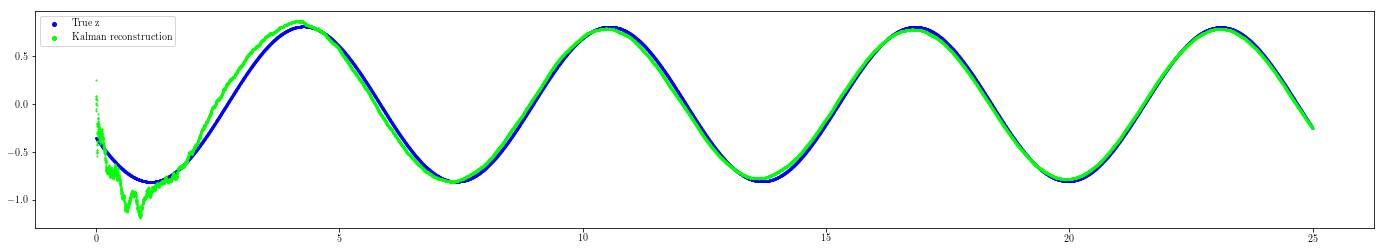

In [18]:
# plot kalman reconstruction of z
plt.figure(figsize=(24, 4))
plt.scatter(times, true_zs, s=1, c=(0, 0, 1))
plt.scatter(times, kalman_zs, s=1, c=(0, 1, 0))
plt.legend(['True z', 'Kalman reconstruction'], markerscale=4)
plt.show()

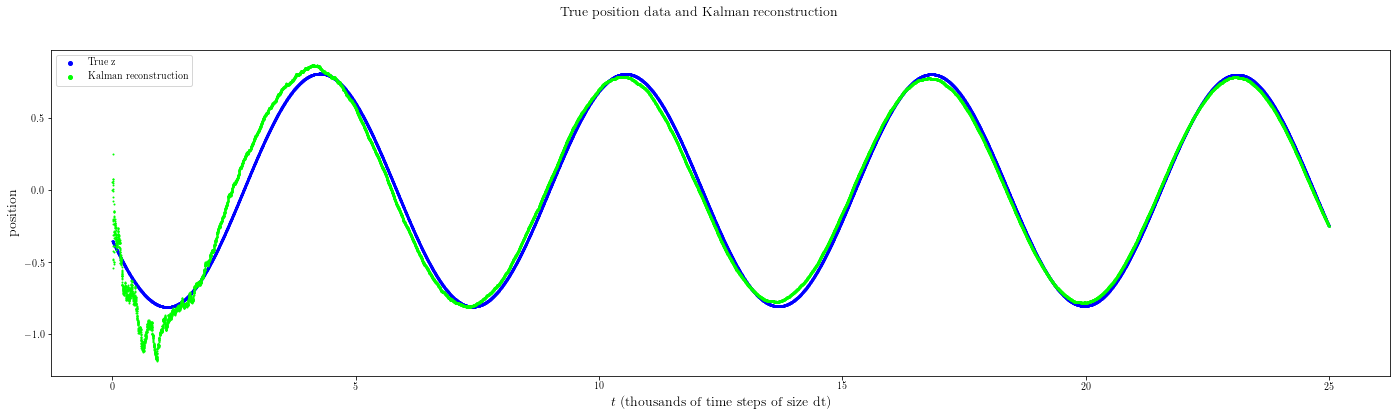

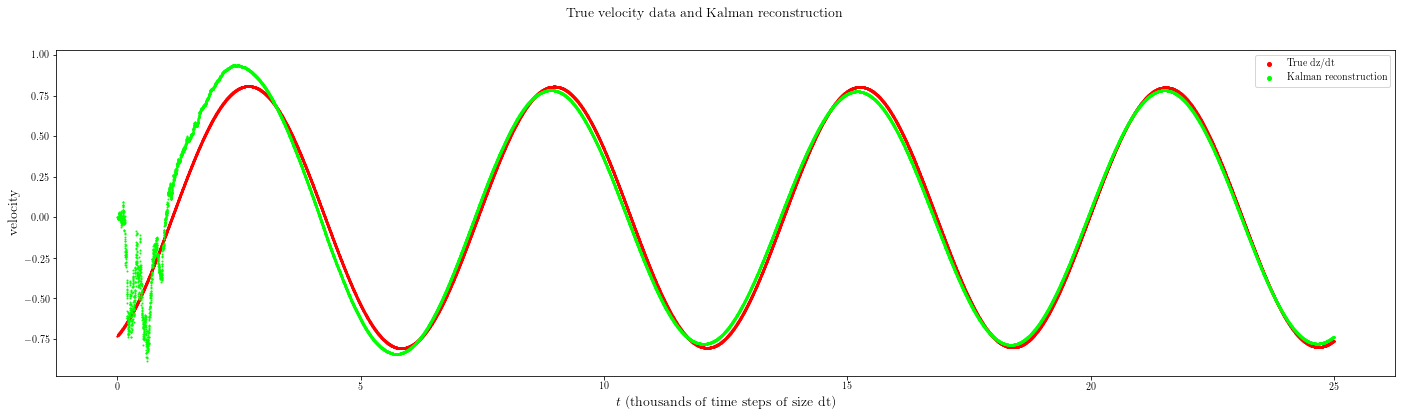

In [19]:
# plot kalman reconstruction of z
plt.figure(figsize=(24, 6))
plt.scatter(times, true_zs, s=1, c=(0, 0, 1))
plt.scatter(times, kalman_zs, s=1, c=(0, 1, 0))
plt.suptitle('True position data and Kalman reconstruction',
             fontsize=14, fontweight='bold')
plt.xlabel(r"$t$"' (thousands of time steps of size dt)',
                  fontsize=14, fontweight='bold')
plt.ylabel('position', fontsize=14, fontweight='bold')
plt.legend(['True z', 'Kalman reconstruction'], markerscale=4)
plt.show()

# plot kalman reconstruction of z_t
plt.figure(figsize=(24, 6))
plt.scatter(times, true_zts, s=1, c=(1, 0, 0))
plt.scatter(times, kalman_zts, s=1, c=(0, 1, 0))
plt.suptitle('True velocity data and Kalman reconstruction',
             fontsize=14, fontweight='bold')
plt.xlabel(r"$t$"' (thousands of time steps of size dt)',
                  fontsize=14, fontweight='bold')
plt.ylabel('velocity', fontsize=14, fontweight='bold')
plt.legend(['True dz/dt', 'Kalman reconstruction'], markerscale=4)
plt.show()

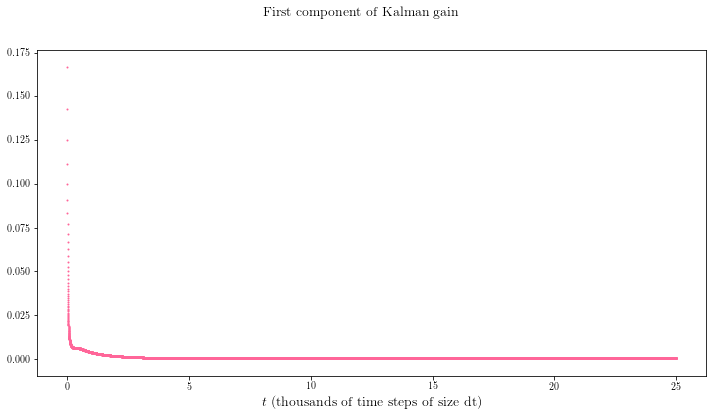

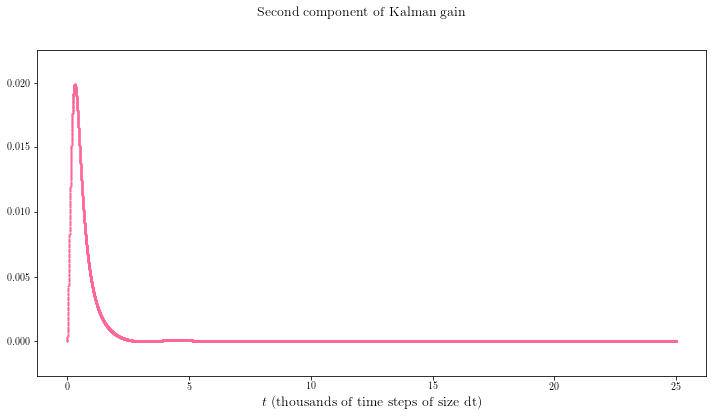

In [20]:
# plot kalman gain components
K0s = [K[0] for K in kalman_gains]
K1s = [K[1] for K in kalman_gains]

plt.figure(figsize=(12, 6))
plt.scatter(times[1:], K0s, s=1, c='#ff6699')
plt.suptitle('First component of Kalman gain',
             fontsize=14, fontweight='bold')
plt.xlabel(r"$t$"' (thousands of time steps of size dt)',
                  fontsize=14, fontweight='bold')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(times[1:], K1s, s=1, c='#ff6699')
plt.suptitle('Second component of Kalman gain',
             fontsize=14, fontweight='bold')
plt.xlabel(r"$t$"' (thousands of time steps of size dt)',
                  fontsize=14, fontweight='bold')
plt.show()

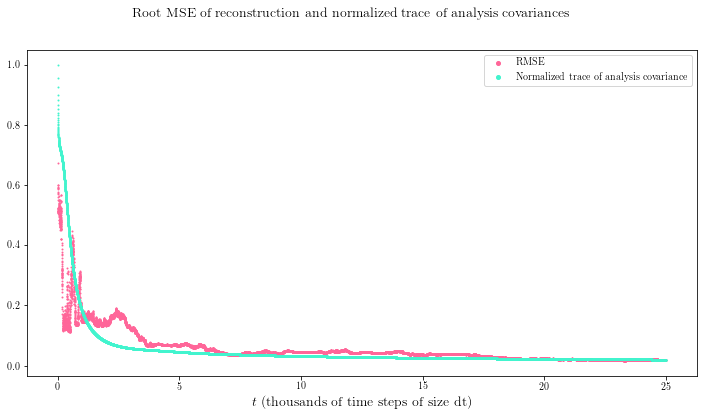

In [21]:
# generate and plots RMSEs and traces of analysis covariances
RMSEs = [np.sqrt(0.5*((true_xs[k][0] - kalman_mus[k][0])**2
                      + (true_xs[k][1] - kalman_mus[k][1])**2))
         for k in range(T+1)]

plt.figure(figsize=(12, 6))
plt.scatter(times, RMSEs, s=1, c='#ff6699')
cov_traces = [np.sqrt(0.5 * np.trace(P)) for P in kalman_Ps]
plt.scatter(times, cov_traces, s=1, c='#42f4ce')
plt.suptitle('Root MSE of reconstruction and normalized trace of analysis covariances',
             fontsize=14, fontweight='bold')
plt.xlabel(r"$t$"' (thousands of time steps of size dt)',
                  fontsize=14, fontweight='bold')
plt.legend(['RMSE', 'Normalized trace of analysis covariance'], markerscale=4)
plt.show()